In [ ]:
import cv2
import numpy as np 
import pandas as pd 
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import datasets, layers, models, losses, Model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pre
from glob import glob
from sklearn.utils.class_weight import compute_class_weight
os.environ["CUDA_VISIBLE_DEVICES"] = '2,3'


In [ ]:
pd_img_list=pd.read_csv('../../data/preprocessing_dataset/data_set.csv')['file_path']
pd_label_list=pd.read_csv('../../data/preprocessing_dataset/data_set.csv')
Train_img_list=pd_img_list[pd_img_list.str.contains('Train')].to_list() ## df[조건식]
Test_img_list=pd_img_list[pd_img_list.str.contains('Test')].to_list() ## df[조건식]
Train_label_list=pd_label_list[pd_label_list['file_path'].str.contains('Train')]['standard_frame'].to_list()
Test_label_list=pd_label_list[pd_label_list['file_path'].str.contains('Test')]['standard_frame'].to_list()

In [ ]:
size=256
x_train = np.zeros((len(Train_img_list),size,size,3))
y_train = np.zeros((len(Train_label_list),1))
for i in range(len(Train_img_list)):
    x_train[i] =np.array(Image.open('../../data/preprocessing_dataset/'+Train_img_list[i]).resize((size,size)))
x_train=x_train/255
y_train=np.array(Train_label_list)

x_test = np.zeros((len(Test_img_list),size,size,3))
y_test = np.zeros((len(Test_label_list),1))
for i in range(len(Test_img_list)):
    x_test[i] =np.array(Image.open('../../data/preprocessing_dataset/'+Test_img_list[i]).resize((size,size)))
x_test=x_test/255
y_test=np.array(Test_label_list)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [20]:

checkpoint_filepath = "../../model/resnet50_preprocessing_checkpoints.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only= True
)
class_weight_ratio=compute_class_weight(class_weight = "balanced" , 
                     classes=np.unique(y_train), 
                     y = y_train)
class_weight = {0:15,1:85}
mirrored_strategy = tf.distribute.MirroredStrategy(devices=['/GPU:0','/GPU:1'])
with mirrored_strategy.scope(): 
    input_t=K.Input(shape=(size,size, 3))
    input_tensor = layers.experimental.preprocessing.Resizing(size, size, interpolation="bilinear", input_shape=x_train.shape[1:])(input_t)
    ResNet=ResNet50(include_top=True,weights='imagenet',input_tensor=input_tensor)
    model = K.models.Sequential()
    model.add(ResNet)
    model.add(tf.keras.layers.Dropout(.2, input_shape=(64,)))
    model.add(K.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
    model.add(K.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=K.optimizers.Adam(lr=2e-4),
                  loss=tf.keras.losses.binary_crossentropy,
                  metrics=["accuracy"])
    histo=model.fit(
        x_train,y_train,
        validation_data=(x_val,y_val),
        epochs=500,
        callbacks=[model_checkpoint_callback],
        batch_size=64,shuffle=True,
        class_weight=class_weight
    )
model.save('../../model/ResNet50_preprocessing256.h5')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/500
INFO:tensorflow:batch_all_reduce: 218 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 218 all-reduces with algorithm = nccl, num_packs = 1
102/102 [==============================] - 37s 196ms/step - loss: 17.0012 - accuracy: 0.7870 - val_loss: 0.6051 - val_accuracy: 0.8496
Epoch 2/500
102/102 [==============================] - 17s 167ms/step - loss: 15.7283 - accuracy: 0.8028 - val_loss: 0.5425 - val_accuracy: 0.8496
Epoch 3/500
102/102 [==============================] - 12s 119ms/step - loss: 14.1085 - accuracy: 0.8330 - val_loss: 0.5490 - val_accuracy: 0.8496
Epoch 4/500
102/102 [==============================] - 16s 162ms/step - loss: 12.8826 - accuracy: 0.8375 - val_loss: 0.4878 - val_accuracy: 0.8496
Epoch 5/500
102/102 [==============================] - 17s 163ms/step - loss: 11.6622 - accuracy: 0.8498 - val_loss: 0.4296 - val_accuracy: 0.8496
Epoch 6/500
102/102 [==============================] - 13s 127ms/step - loss: 10.4000 - acc

KeyboardInterrupt: 

26/26 [==============================] - 1s 23ms/step


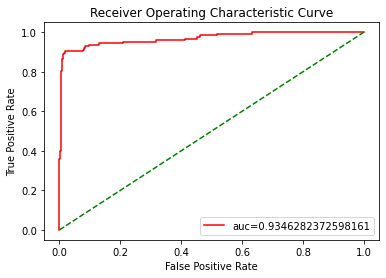

                  precision    recall  f1-score   support

NotStandardFrame       0.98      0.99      0.98       684
   StandardFrame       0.93      0.88      0.91       126

        accuracy                           0.97       810
       macro avg       0.96      0.93      0.94       810
    weighted avg       0.97      0.97      0.97       810



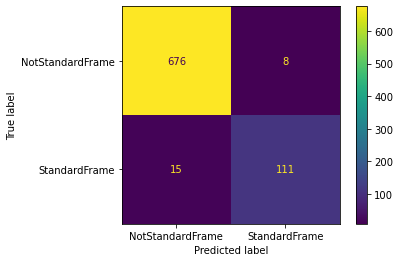

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
def plot_roc_curve(fper, tper):
    
    plt.plot(fper, tper, color='red', label='auc='+str(auc_score))
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

model = K.models.load_model('../../model/resnet50_preprocessing_checkpoints.h5')
classes = ['NotStandardFrame','StandardFrame']
prob = model.predict(x_test)
t_prob=np.where(prob>0.5,1,0)
fper, tper, thresholds = roc_curve(y_test, prob)
auc_score=roc_auc_score(y_test, t_prob)
plot_roc_curve(fper, tper)
cm = confusion_matrix(y_test, t_prob)
cm_display = ConfusionMatrixDisplay(cm,
                              display_labels=classes).plot()


# F1 점수, 재현율, 정밀도 계산
report = classification_report(y_test, t_prob, target_names=classes)

# 결과 출력
print(report)
